<a href="https://colab.research.google.com/github/JyothiPrasad1304/HCL_Hackathon/blob/main/HCLTech_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install faker

In [ ]:
import pandas as pd
import numpy as np
from faker import Faker
from datetime import datetime, timedelta
import random
import os

fake = Faker()
random.seed(42)
np.random.seed(42)


NUM_STORES = 5
NUM_PRODUCTS = 30
NUM_CUSTOMERS = 120
NUM_PROMOTIONS = 5
NUM_RULES = 3
NUM_TRANSACTIONS = 700
DAYS = 7

os.makedirs("data/raw", exist_ok=True)


stores = pd.DataFrame({
    "store_id": range(1, NUM_STORES + 1),
    "store_name": [f"{fake.company()} Store" for _ in range(NUM_STORES)],
    "store_city": [fake.city() for _ in range(NUM_STORES)],
    "store_region": [fake.state() for _ in range(NUM_STORES)],
    "opening_date": [fake.date_between("-8y", "-1y") for _ in range(NUM_STORES)]
})


categories = ["Electronics", "Apparel", "Grocery", "Home", "Beauty"]

products = pd.DataFrame({
    "product_id": range(1, NUM_PRODUCTS + 1),
    "product_name": [fake.word().capitalize() for _ in range(NUM_PRODUCTS)],
    "product_category": np.random.choice(categories, NUM_PRODUCTS),
    "unit_price": np.round(np.random.uniform(50, 2000, NUM_PRODUCTS), 2),
    "current_stock_level": np.random.randint(20, 1000, NUM_PRODUCTS)
})

#
customer_segments = ["HS", "AR", "REG"]

customers = pd.DataFrame({
    "customer_id": range(1, NUM_CUSTOMERS + 1),
    "first_name": [fake.first_name() for _ in range(NUM_CUSTOMERS)],
    "email": [fake.email() for _ in range(NUM_CUSTOMERS)],
    "loyalty_status": np.random.choice(["Bronze", "Silver", "Gold"], NUM_CUSTOMERS),
    "total_loyalty_points": np.random.randint(0, 5000, NUM_CUSTOMERS),
    "last_purchase_date": [fake.date_between("-60d", "today") for _ in range(NUM_CUSTOMERS)],
    "segment_id": np.random.choice(customer_segments, NUM_CUSTOMERS),
    "customer_phone": [fake.msisdn()[:10] for _ in range(NUM_CUSTOMERS)],
    "customer_since": [fake.date_between("-5y", "-6m") for _ in range(NUM_CUSTOMERS)]
})


promotions = pd.DataFrame({
    "promotion_id": range(1, NUM_PROMOTIONS + 1),
    "promotion_name": [f"{fake.word().capitalize()} Sale" for _ in range(NUM_PROMOTIONS)],
    "start_date": [fake.date_between("-30d", "-10d") for _ in range(NUM_PROMOTIONS)],
    "end_date": [fake.date_between("today", "+20d") for _ in range(NUM_PROMOTIONS)],
    "discount_percentage": np.round(np.random.uniform(5, 30, NUM_PROMOTIONS), 2),
    "applicable_category": np.random.choice(categories + ["ALL"], NUM_PROMOTIONS)
})


loyalty_rules = pd.DataFrame({
    "rule_id": range(1, NUM_RULES + 1),
    "rule_name": ["Standard Earning", "High Spend Bonus", "Weekend Bonus"],
    "points_per_unit_spend": [1.0, 1.5, 2.0],
    "min_spend_threshold": [0, 500, 300],
    "bonus_points": [0, 200, 100]
})


transactions = []
for txn_id in range(1, NUM_TRANSACTIONS + 1):


    customer_id = random.choice(
        [None] + list(range(1, NUM_CUSTOMERS + 1))
    )

    total_amount = round(random.uniform(100, 5000), 2)

    if random.random() < 0.04:
        total_amount = -total_amount

    transactions.append({
        "transaction_id": f"TXN{100000 + txn_id}",
        "customer_id": customer_id,
        "store_id": random.randint(1, NUM_STORES),
        "transaction_date": datetime.now() - timedelta(days=random.randint(0, DAYS)),
        "total_amount": total_amount,
        "customer_phone": fake.msisdn()[:10]
    })

store_sales_header = pd.DataFrame(transactions)

line_items = []
line_id = 1

for _, txn in store_sales_header.iterrows():
    num_items = random.randint(1, 5)

    for _ in range(num_items):
        product = products.sample(1).iloc[0]
        quantity = random.randint(1, 4)

        promotion_id = (
            random.choice(promotions["promotion_id"].tolist())
            if random.random() < 0.3 else None
        )

        line_items.append({
            "line_item_id": line_id,
            "transaction_id": txn["transaction_id"],
            "product_id": product["product_id"],
            "promotion_id": promotion_id,
            "quantity": quantity,
            "line_item_amount": round(quantity * product["unit_price"], 2)
        })
        line_id += 1

store_sales_line_items = pd.DataFrame(line_items)


stores.to_csv("data/raw/stores.csv", index=False)
products.to_csv("data/raw/products.csv", index=False)
customers.to_csv("data/raw/customer_details.csv", index=False)
promotions.to_csv("data/raw/promotion_details.csv", index=False)
loyalty_rules.to_csv("data/raw/loyalty_rules.csv", index=False)
store_sales_header.to_csv("data/raw/store_sales_header.csv", index=False)
store_sales_line_items.to_csv("data/raw/store_sales_line_items.csv", index=False)

In [ ]:
stores_df = pd.read_csv("data/raw/stores.csv")
products_df = pd.read_csv("data/raw/products.csv")
customers_df = pd.read_csv("data/raw/customer_details.csv")
promotions_df = pd.read_csv("data/raw/promotion_details.csv")
loyalty_rules_df = pd.read_csv("data/raw/loyalty_rules.csv")
sales_header_df = pd.read_csv("data/raw/store_sales_header.csv")
sales_lines_df = pd.read_csv("data/raw/store_sales_line_items.csv")

# 1️⃣ Merge transaction header with line items
merged_df = pd.merge(
    sales_lines_df,
    sales_header_df,
    on="transaction_id",
    how="left"
)

# 2️⃣ Merge product details
merged_df = pd.merge(
    merged_df,
    products_df,
    on="product_id",
    how="left"
)

# 3️⃣ Merge customer details
merged_df = pd.merge(
    merged_df,
    customers_df,
    on="customer_id",
    how="left"
)

# 4️⃣ Merge store details
merged_df = pd.merge(
    merged_df,
    stores_df,
    on="store_id",
    how="left"
)

# 5️⃣ Merge promotion details
merged_df = pd.merge(
    merged_df,
    promotions_df,
    on="promotion_id",
    how="left"
)

# Save final combined dataset
os.makedirs("data/processed", exist_ok=True)
merged_df.to_csv("store_sales_dataset.csv", index=False)

print("✅ All CSV files successfully combined into data/processed/retail_master_dataset.csv")

✅ All CSV files successfully combined into data/processed/retail_master_dataset.csv


In [ ]:
len(merged_df)

2205

In [ ]:
#Error check

# 1. Missing customer_id
missing_customer = merged_df["customer_id"].isna().sum()

# 2. Negative total_amount
negative_amount = (merged_df["total_amount"] < 0).sum()

# 3. Future transaction_date
future_dates = (
    pd.to_datetime(merged_df["transaction_date"], errors="coerce") > pd.Timestamp.now()
).sum()

print("Pre-validation report:")
print("Missing customer_id:", missing_customer)
print("Negative total_amount:", negative_amount)
print("Future transaction_date:", future_dates)


Pre-validation report:
Missing customer_id: 12
Negative total_amount: 115
Future transaction_date: 0


In [ ]:
#from google.colab import files
#files.download("store_sales_header.csv")

In [ ]:
def validate_row(row):
    errors = []

    # ---------- ID RULES ----------
    if pd.isna(row["transaction_id"]):
        errors.append("transaction_id is NULL")

    if pd.isna(row["store_id"]):
        errors.append("store_id is NULL")

    # customer_id can be NULL (unidentified spend),
    # but NOT allowed for loyalty calculations
    if pd.isna(row["customer_id"]):
        errors.append("customer_id is NULL")

    # ---------- NUMERIC RULES ----------
    if pd.isna(row["total_amount"]) or row["total_amount"] < 0:
        errors.append("Total amount is Negative or NULL")

    # ---------- DATE RULES ----------
    try:
        txn_date = pd.to_datetime(row["transaction_date"])
        if txn_date > pd.Timestamp.now():
            errors.append("transaction_date is in the future")
    except:
        errors.append("transaction_date invalid format")

    return errors

In [ ]:
clean_rows = []
bad_rows = []

for _, row in merged_df.iterrows():
    error_list = validate_row(row)

    if len(error_list) == 0:
        clean_rows.append(row)
    else:
        bad_row = row.to_dict()
        bad_row["error_reason"] = "; ".join(error_list)
        bad_rows.append(bad_row)

clean_df = pd.DataFrame(clean_rows)
bad_df = pd.DataFrame(bad_rows)

print("Clean data shape:", clean_df.shape)
print("Bad data shape:", bad_df.shape)

NameError: name 'df' is not defined

In [ ]:
print("Sample Clean Data")
clean_df.head()

Sample Clean Data


,line_item_id,transaction_id,product_id,promotion_id,quantity,line_item_amount,customer_id,store_id,transaction_date,total_amount,...,customer_since,store_name,store_city,store_region,opening_date,promotion_name,start_date,end_date,discount_percentage,applicable_category
0,1,TXN100001,26,1.0,2,2232.18,81.0,2,2026-02-01 08:11:01.543167,645.52,...,2025-01-27,"Arellano, Clark and Phelps Store",Wolfeland,Minnesota,2019-09-15,Deep Sale,2026-01-06,2026-02-08,21.43,Grocery
1,2,TXN100001,6,3.0,1,1205.21,81.0,2,2026-02-01 08:11:01.543167,645.52,...,2025-01-27,"Arellano, Clark and Phelps Store",Wolfeland,Minnesota,2019-09-15,Next Sale,2026-01-23,2026-02-09,23.25,ALL
2,3,TXN100001,24,NaN,3,1973.52,81.0,2,2026-02-01 08:11:01.543167,645.52,...,2025-01-27,"Arellano, Clark and Phelps Store",Wolfeland,Minnesota,2019-09-15,NaN,NaN,NaN,NaN,NaN
3,4,TXN100001,10,NaN,1,176.85,81.0,2,2026-02-01 08:11:01.543167,645.52,...,2025-01-27,"Arellano, Clark and Phelps Store",Wolfeland,Minnesota,2019-09-15,NaN,NaN,NaN,NaN,NaN
4,5,TXN100001,18,1.0,4,1151.88,81.0,2,2026-02-01 08:11:01.543167,645.52,...,2025-01-27,"Arellano, Clark and Phelps Store",Wolfeland,Minnesota,2019-09-15,Deep Sale,2026-01-06,2026-02-08,21.43,Grocery


In [ ]:
print("Sample Bad Data")
bad_df[["transaction_id", "error_reason"]].head()

Sample Bad Data


,transaction_id,error_reason
0,TXN100003,Total amount is Negative or NULL
1,TXN100003,Total amount is Negative or NULL
2,TXN100003,Total amount is Negative or NULL
3,TXN100024,Total amount is Negative or NULL
4,TXN100024,Total amount is Negative or NULL


In [ ]:
clean_df.to_csv("clean_store_sales_header.csv", index=False)
bad_df.to_csv("bad_store_sales_header.csv", index=False)

In [ ]:
from google.colab import files
files.download("clean_store_sales_header.csv")
files.download("bad_store_sales_header.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# creating different dataframes

In [24]:
from datetime import datetime, timedelta

def customer_segmentation(df_transactions, df_customers):
    df = df_transactions.copy()

    # Ensure datetime
    df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')

    # ---------------------------------
    # TOP 10% SPENDERS
    # ---------------------------------
    spend_summary = (
        df.groupby('customer_id')
          .agg(
              total_lifetime_spend=('total_amount', 'sum'),
              transaction_count=('transaction_id', 'count')
          )
          .reset_index()
    )

    spend_threshold = spend_summary['total_lifetime_spend'].quantile(0.90)

    top_10_percent_spenders = spend_summary[
        spend_summary['total_lifetime_spend'] >= spend_threshold
    ].sort_values(by='total_lifetime_spend', ascending=False)

    top_10_percent_spenders = top_10_percent_spenders.merge(
        df_customers[['customer_id', 'first_name', 'loyalty_status']],
        on='customer_id',
        how='left'
    )

    # ---------------------------------
    # INACTIVE CUSTOMERS (30+ DAYS)
    # ---------------------------------
    last_purchase = (
        df.groupby('customer_id')
          .agg(last_purchase_date=('transaction_date', 'max'))
          .reset_index()
    )

    cutoff_date = pd.Timestamp(datetime.now().date() - timedelta(days=30))

    inactive_customers = last_purchase[
        last_purchase['last_purchase_date'] < cutoff_date
    ]

    inactive_customers = inactive_customers.merge(
        df_customers[['customer_id', 'first_name', 'loyalty_status']],
        on='customer_id',
        how='left'
    )

    return top_10_percent_spenders, inactive_customers

In [25]:
top_spenders_df, inactive_customers_df = customer_segmentation(
    transactions_with_points,
    customers
)

In [26]:
# ---------------------------------
# Transaction-level loyalty output
# ---------------------------------
print("--- Transaction Level Accrual ---")
print(transactions_with_points[['transaction_id', 'total_amount', 'accrued_points']].head())

print("\n--- Final Customer Loyalty Balance ---")
print(customer_loyalty_totals.head())

# ---------------------------------
# Top 10% Spenders
# ---------------------------------
print("\n--- Top 10% Spenders ---")
print(
    top_spenders_df[
        ['customer_id', 'first_name', 'loyalty_status',
         'total_lifetime_spend', 'transaction_count']
    ].head()
)

# ---------------------------------
# Inactive Customers (30+ Days)
# ---------------------------------
print("\n--- Inactive Customers (30+ Days) ---")
print(
    inactive_customers_df[
        ['customer_id', 'first_name', 'loyalty_status', 'last_purchase_date']
    ].head()
)

--- Transaction Level Accrual ---
  transaction_id  total_amount  accrued_points
0      TXN100001        645.52           645.0
1      TXN100002       3708.71          3708.0
2      TXN100003      -2167.42         -2168.0
3      TXN100004       3049.89          3049.0
4      TXN100005       2301.12          2301.0

--- Final Customer Loyalty Balance ---
   customer_id  total_loyalty_points  total_lifetime_spend  transaction_count
0            1               13244.0              13247.88                  7
1            2                6780.0               6783.11                  6
2            3               14271.0              14272.63                  5
3            4                5955.0               5956.52                  3
4            5               16836.0              16840.00                  8

--- Top 10% Spenders ---
   customer_id first_name loyalty_status  total_lifetime_spend  \
0           44   Benjamin           Gold              37730.94   
1           97    

In [39]:
import pandas as pd
from datetime import datetime

def calculate_rfm(df_transactions):
    """
    Calculates Recency, Frequency, Monetary (RFM) metrics per customer.
    """

    df = df_transactions.copy()

    # Ensure datetime
    df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')

    # Reference date (today)
    snapshot_date = pd.Timestamp(datetime.now().date())

    # RFM calculation
    rfm = (
        df.groupby('customer_id')
          .agg(
              Recency=('transaction_date', lambda x: (snapshot_date - x.max()).days),
              Frequency=('transaction_id', 'count'),
              Monetary=('total_amount', 'sum')
          )
          .reset_index()
    )

    return rfm

In [42]:
rfm_df = calculate_rfm(transactions_with_points)

In [43]:
print(rfm_df)

     customer_id  Recency  Frequency  Monetary
0              1        1          7  13247.88
1              2        0          6   6783.11
2              3        1          5  14272.63
3              4       -1          3   5956.52
4              5       -1          8  16840.00
..           ...      ...        ...       ...
115          116        2          4  14132.67
116          117        0          7   7229.52
117          118       -1          4  10678.42
118          119       -1          5   8119.82
119          120       -1          6  18244.35

[120 rows x 4 columns]


In [44]:
import pandas as pd

def update_or_insert_customers(transactions_df, customers_df):
    """
    Updates loyalty points for existing customers
    and inserts new customers if not present.
    """

    # Work on a copy to avoid side effects
    customers = customers_df.copy()
    transactions = transactions_df.copy()

    # Ensure datetime
    transactions['transaction_date'] = pd.to_datetime(
        transactions['transaction_date'], errors='coerce'
    )
    customers['last_purchase_date'] = pd.to_datetime(
        customers['last_purchase_date'], errors='coerce'
    )

    for _, txn in transactions.iterrows():
        cust_id = txn['customer_id']
        txn_date = txn['transaction_date']
        points = txn['accrued_points']
        phone = txn.get('customer_phone', None)

        # -------------------------
        # EXISTING CUSTOMER
        # -------------------------
        if cust_id in customers['customer_id'].values:
            customers.loc[
                customers['customer_id'] == cust_id,
                'total_loyalty_points'
            ] += points

            customers.loc[
                customers['customer_id'] == cust_id,
                'last_purchase_date'
            ] = max(
                customers.loc[
                    customers['customer_id'] == cust_id,
                    'last_purchase_date'
                ].iloc[0],
                txn_date
            )

        # -------------------------
        # NEW CUSTOMER
        # -------------------------
        else:
            new_customer = {
                'customer_id': cust_id,
                'total_loyalty_points': points,
                'last_purchase_date': txn_date,
                'customer_phone': phone,
                'customer_since': txn_date
            }

            customers = pd.concat(
                [customers, pd.DataFrame([new_customer])],
                ignore_index=True
            )

    return customers

In [47]:
updated_customers_df = update_or_insert_customers(
    transactions_with_points,
    customers_df
)

In [48]:
print(updated_customers_df)

     customer_id first_name                       email loyalty_status  \
0              1     Nicole     karendillon@example.com           Gold   
1              2    Lindsey         jorge15@example.org         Bronze   
2              3     Steven  thompsonkelsey@example.com         Bronze   
3              4       Mary       fpeterson@example.net           Gold   
4              5    William           aking@example.net           Gold   
..           ...        ...                         ...            ...   
115          116       Lynn     jonesangela@example.net           Gold   
116          117     Rodney    mirandawhite@example.com         Bronze   
117          118    Jillian          mary31@example.com         Silver   
118          119    Michael     sarahwright@example.net         Silver   
119          120    Brandon       cynthia65@example.net         Silver   

     total_loyalty_points         last_purchase_date segment_id  \
0                   14098 2026-02-02 12:08:2

In [57]:
import pandas as pd
from datetime import datetime

def update_or_insert_customer_manual(customers_df):
    """
    Takes user input to update loyalty points for an existing customer
    or insert a new customer if not found.
    """

    customers = customers_df.copy()

    # Take user inputs
    customer_id = input("Enter customer ID: ").strip()
    first_name = input("Enter customer name: ").strip()
    points_to_add = int(input("Enter loyalty points to add: "))

    today = pd.Timestamp(datetime.now().date())

    # -------------------------
    # EXISTING CUSTOMER
    # -------------------------
    if customer_id in customers['customer_id'].astype(str).values:
        customers.loc[
            customers['customer_id'].astype(str) == customer_id,
            'total_loyalty_points'
        ] += points_to_add

        customers.loc[
            customers['customer_id'].astype(str) == customer_id,
            'first_name'
        ] = first_name

        customers.loc[
            customers['customer_id'].astype(str) == customer_id,
            'last_purchase_date'
        ] = today

        print(f"✅ Updated existing customer: {customer_id}")

    # -------------------------
    # NEW CUSTOMER
    # -------------------------
    else:
        new_customer = {
            'customer_id': customer_id,
            'first_name': first_name,
            'total_loyalty_points': points_to_add,
            'last_purchase_date': today,
            'customer_since': today
        }

        customers = pd.concat(
            [customers, pd.DataFrame([new_customer])],
            ignore_index=True
        )

        print(f"🆕 Added new customer: {customer_id}")

    return customers

In [58]:
customers_df = update_or_insert_customer_manual(customers_df)
print(customers_df)

Enter customer ID: 1
Enter customer name: Nicole
Enter loyalty points to add: 22
✅ Updated existing customer: 1
    customer_id first_name                       email loyalty_status  \
0             1     Nicole     karendillon@example.com           Gold   
1             2    Lindsey         jorge15@example.org         Bronze   
2             3     Steven  thompsonkelsey@example.com         Bronze   
3             4       Mary       fpeterson@example.net           Gold   
4             5    William           aking@example.net           Gold   
..          ...        ...                         ...            ...   
116         117     Rodney    mirandawhite@example.com         Bronze   
117         118    Jillian          mary31@example.com         Silver   
118         119    Michael     sarahwright@example.net         Silver   
119         120    Brandon       cynthia65@example.net         Silver   
120       12345        NaN                         NaN            NaN   

     total_

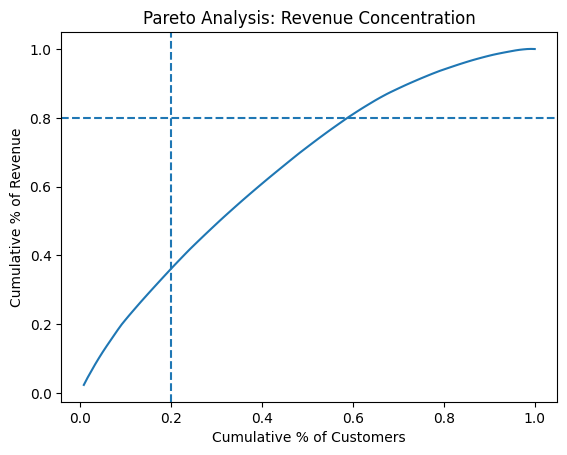

/tmp/ipython-input-2445677247.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_rf = rfm_df.pivot_table(


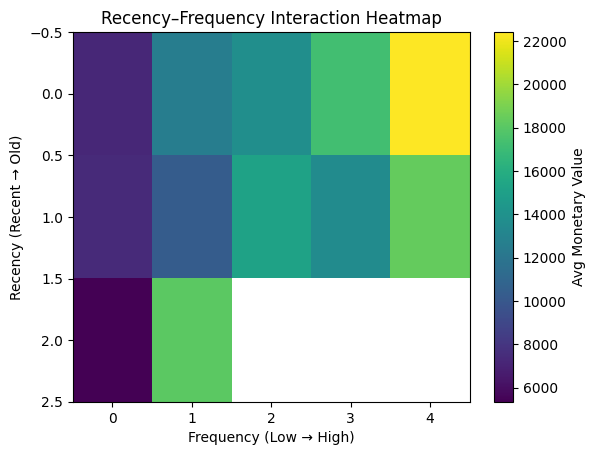

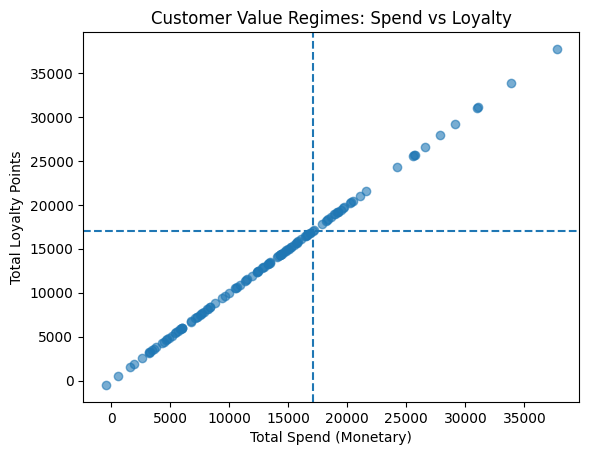

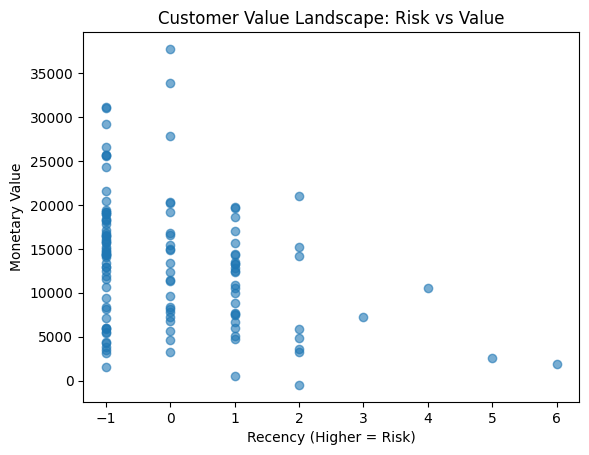

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# 1️⃣ PARETO CURVE — VALUE CONCENTRATION
# -------------------------------------------------
rfm_sorted = rfm_df.sort_values("Monetary", ascending=False)

rfm_sorted["cum_revenue"] = rfm_sorted["Monetary"].cumsum()
rfm_sorted["cum_revenue_pct"] = (
    rfm_sorted["cum_revenue"] / rfm_sorted["Monetary"].sum()
)

rfm_sorted["customer_pct"] = (
    np.arange(1, len(rfm_sorted) + 1) / len(rfm_sorted)
)

plt.figure()
plt.plot(rfm_sorted["customer_pct"], rfm_sorted["cum_revenue_pct"])
plt.axhline(0.8, linestyle="--")
plt.axvline(0.2, linestyle="--")
plt.xlabel("Cumulative % of Customers")
plt.ylabel("Cumulative % of Revenue")
plt.title("Pareto Analysis: Revenue Concentration")
plt.show()

# -------------------------------------------------
# 2️⃣ RECENCY × FREQUENCY INTERACTION (HEATMAP)
# -------------------------------------------------
rfm_df["recency_bin"] = pd.qcut(
    rfm_df["Recency"], 5, duplicates="drop"
)

rfm_df["frequency_bin"] = pd.qcut(
    rfm_df["Frequency"], 5, duplicates="drop"
)

pivot_rf = rfm_df.pivot_table(
    values="Monetary",
    index="recency_bin",
    columns="frequency_bin",
    aggfunc="mean"
)

plt.figure()
plt.imshow(pivot_rf, aspect="auto")
plt.colorbar(label="Avg Monetary Value")
plt.xlabel("Frequency (Low → High)")
plt.ylabel("Recency (Recent → Old)")
plt.title("Recency–Frequency Interaction Heatmap")
plt.show()

# -------------------------------------------------
# 3️⃣ MONETARY vs LOYALTY REGIME MAP
# -------------------------------------------------
merged_loyalty = customer_loyalty_totals.merge(
    rfm_df[["customer_id", "Monetary"]],
    on="customer_id",
    how="left"
)

plt.figure()
plt.scatter(
    merged_loyalty["Monetary"],
    merged_loyalty["total_loyalty_points"],
    alpha=0.6
)

plt.axvline(
    merged_loyalty["Monetary"].quantile(0.75),
    linestyle="--"
)
plt.axhline(
    merged_loyalty["total_loyalty_points"].quantile(0.75),
    linestyle="--"
)

plt.xlabel("Total Spend (Monetary)")
plt.ylabel("Total Loyalty Points")
plt.title("Customer Value Regimes: Spend vs Loyalty")
plt.show()

# -------------------------------------------------
# 4️⃣ CUSTOMER VALUE LANDSCAPE (RISK vs VALUE)
# -------------------------------------------------
plt.figure()
plt.scatter(
    rfm_df["Recency"],
    rfm_df["Monetary"],
    alpha=0.6
)

plt.xlabel("Recency (Higher = Risk)")
plt.ylabel("Monetary Value")
plt.title("Customer Value Landscape: Risk vs Value")
plt.show()